## Config GPT 2

In [30]:
!which python

/Users/jagpreetsingh/ML_Projects/text-sql/.venv/bin/python


In [31]:
import torch.nn as nn
import torch
import tiktoken


In [32]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # vocabulary size
    "ctx_len" : 1024,     # context length
    "emb_dim" : 768,      # embedding dimesension
    "n_head" : 12,        # number of attention heads
    "n_layers" : 12,      # number of layers
    "drop_rate" : 0.1,    # Dropout rate
    "qkv_bias" : False
}

In [33]:

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # a placeholder

    def forward(self, x):
        ## this block does nothing just returns its input
        return x
    



In [34]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [35]:

class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        ## use a place holder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [36]:
tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [37]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

logits = model(batch)
print(f"Output shape: {logits.shape}")
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.7867,  0.2203, -0.4508,  ..., -0.9936, -0.1412, -0.2999],
         [-0.0788,  0.3004, -0.2935,  ...,  0.1583,  0.8917,  0.8230],
         [ 0.3708,  1.1126, -0.3226,  ...,  0.8023, -0.0038,  0.3935],
         [ 0.0636,  1.0572, -0.2507,  ...,  0.7542, -0.0750, -0.6896]],

        [[-0.7208,  0.1351, -0.6014,  ..., -1.0272,  0.1729, -0.2920],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)


In [38]:
torch.manual_seed(123)

## create a training sample with 5 dimensions

batch_example = torch.randn(2, 5)

# print(batch_example)

layer = nn.Sequential(nn.Linear(5, 6), 
                      nn.ReLU()
)
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [39]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

torch.set_printoptions(sci_mode=False)

print(f"Mean: \n {mean}")

print(f"Variance: \n {var}")

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [40]:
out_norm = (out - mean) / torch.sqrt(var)
print(f"Normalized layer outputs: \n {out_norm}")

mean_out = out_norm.mean(dim=-1, keepdim=True)
var_out = out_norm.var(dim=-1, keepdim=True)

print(f"mean:\n {mean_out}")
print(f"variance:\n{var_out}")


Normalized layer outputs: 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
variance:
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [41]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

print(f"Mean:\n{mean}")
print(f"Variance:\n{var}")


Mean:
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [42]:
class GELU(nn.Module):
    
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.44715 * torch.pow(x, 3))
        ))




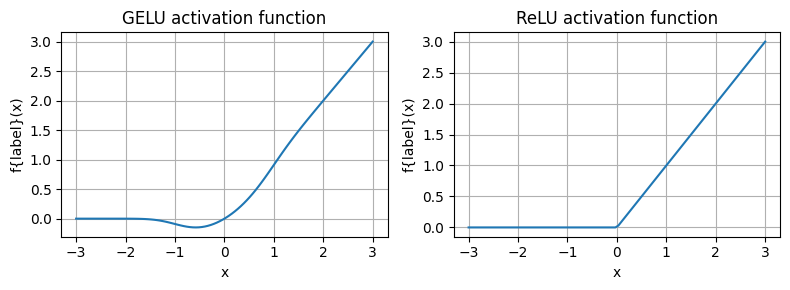

In [43]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

## some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu  = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel("f{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
class FeedForward(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg['drop_rate'])
        )

    def forward(self, x):
        return self.layers(x)

In [45]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [46]:
ffn = FeedForward(GPT_CONFIG_124M)

## input shape: [batch_size, num_token, emb_size]

x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [47]:
class DeepNeuralNetwork(nn.Module):
    
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # compute the output of the current layer
            layer_output = layer(x)
            # check if shortcut can be applied
            if self.use_shortcut and x.size() == layer_output.size():
                x = x + layer_output
            else:
                x = layer_output
        return x


In [48]:
def print_gradients(model, x):
    # forward pass
    output = model(x)
    target = torch.tensor([[0.1]])


    # calculate loss based on how close the target
    ## and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    ## backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            # print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [49]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)

model_without_shortcut = DeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00013063954247627407
layers.1.0.weight has gradient mean of 7.86080927355215e-05
layers.2.0.weight has gradient mean of 0.00046871131053194404
layers.3.0.weight has gradient mean of 0.0008852033643051982
layers.4.0.weight has gradient mean of 0.0032077012583613396


In [50]:
torch.manual_seed(123)
model_with_shortcut = DeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.2653754949569702
layers.1.0.weight has gradient mean of 0.24386566877365112
layers.2.0.weight has gradient mean of 0.4032581150531769
layers.3.0.weight has gradient mean of 0.3219233751296997
layers.4.0.weight has gradient mean of 1.5637577772140503


## Connecting attention and linear layers in a transformer block

In [51]:
import sys
sys.path.append("../")
from components.multi_head import MultiHeadAttention

class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            block_size=cfg["ctx_len"],
            num_heads=cfg["n_head"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        ## shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + shortcut ## add the original input back

        ## shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x

In [52]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768) # [batch_size, num_tokens, emb_dim]

block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")




Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT

In [ ]:
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
            )
        
        self.final_norm = LayerNorm(cfg["emb_dim="],)
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds # [batch_size, num_tokens, emb_size]
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [55]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [54]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print(f"Input batch:\n {batch}")
print(f"Output shape:\n {out.shape}")
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape:
 torch.Size([2, 4, 50257])
tensor([[[ 0.2812,  0.1256,  0.3689,  ...,  0.2658, -0.3893, -0.0773],
         [ 0.5875, -0.4820, -0.6620,  ..., -0.2186, -0.0966,  0.1721],
         [ 0.5021,  0.2563, -0.5852,  ...,  0.4423, -0.9616, -0.1411],
         [-0.8237,  0.5510, -0.3203,  ...,  1.0841,  0.0389, -0.2639]],

        [[-0.0169, -0.3316,  0.6922,  ...,  0.2520, -0.3384, -0.5590],
         [ 0.1938, -0.0155, -0.3590,  ...,  0.8611, -0.4560,  0.5901],
         [ 1.2741,  0.4105, -0.3955,  ...,  0.8096, -0.1016, -0.2602],
         [ 0.4628, -0.1569,  0.4627,  ...,  1.4855, -0.7294,  0.0508]]],
       grad_fn=<UnsafeViewBackward0>)


In [61]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [62]:
total_params_gpt2  = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Total params for GPT 2 for weight tying: {total_params_gpt2:,}")

Total params for GPT 2 for weight tying: 124,412,160


In [65]:
total_size_byte = total_params * 4

total_size_mb = total_size_byte / (1024 * 1024)

print(F"Total size pf the model: {total_size_mb:.2f}MB")

Total size pf the model: 621.83MB


In [66]:
## Genarate Text

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]

        # get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        ## focus only on the last time step
        logits = logits[:, -1,:]

        ## apply softmax to get the probalities
        probas = torch.softmax(logits, dim=-1)

        # get the idx of the vocab entry with the highest probabilities value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        ## append sampled index to the running sequence

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [83]:
b = logits[0, -1, :]
b[0] = - 1.4929
b[1] = 4.4812
b[2] = -1.6093

print(b[:3])
torch.softmax(b, dim=0)

tensor([-1.4929,  4.4812, -1.6093], grad_fn=<SliceBackward0>)


tensor([    0.0000,     0.0078,     0.0000,  ...,     0.0000,     0.0000,
            0.0000], grad_fn=<SoftmaxBackward0>)

In [87]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"encoded tensor {encoded_tensor}")


encoded: [15496, 11, 314, 716]
encoded tensor tensor([[15496,    11,   314,   716]])


In [90]:
model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=1,
    context_size=GPT_CONFIG_124M["ctx_len"]
)

print(f"Output: {out}")
print(f"output length: {len(out[0])}")

Output: tensor([[15496,    11,   314,   716, 23307]])
output length: 5


In [93]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I amToo'